In [7]:
import shutil
from pathlib import Path
import json
from tqdm import tqdm

import torch
import nibabel as nib

from slice_inflate.datasets.clinical_cardiac_views import get_sub_sp_tensor, display_clinical_views, get_clinical_cardiac_view_affines
from slice_inflate.utils.nifti_utils import crop_around_label_center

In [8]:
C3D = "/home/weihsbach/storage/staff/christianweihsbach/c3d/c3d-1.4.0-Linux-gcc64/bin/c3d"
MMWHS_BASE_PATH = "../../data/datasets/MMWHS"


test_cases = [1007,1008] # These look very strange. better to exclude them -> perform 3-fold cross-validation
train_cases = set(range(1001,1021)) - set(test_cases)
train_cases = list(train_cases)
NUM_FOLDS = 3

assert Path(MMWHS_BASE_PATH).is_dir()

split_file_path = Path(MMWHS_BASE_PATH, 'prepared_files/metadata/data_split.json')
split_file_path.parent.mkdir(exist_ok=True, parents=True)
metadata_file_path = Path(MMWHS_BASE_PATH, 'prepared_files/metadata/metadata.json')

# Split dataset

In [9]:
if True:
    # Copy the files
    base_ct_paths = list(Path(MMWHS_BASE_PATH, 'base_files/ct_train').glob('*.nii.gz'))
    base_mr_paths = list(Path(MMWHS_BASE_PATH, 'base_files/mr_train').glob('*.nii.gz'))

    # base_paths = base_ct_paths + base_mr_paths
    base_paths = base_mr_paths

    for p in tqdm(base_paths):
        dest_path = Path(MMWHS_BASE_PATH, 'prepared_files', p.name)
        dest_path.parent.mkdir(exist_ok=True)
        tqdm.write(f"{p} -> {dest_path}")
        shutil.copy(p, dest_path)

if True:
    # Split the copied files
    def get_fold_idxs_dict(paths):
        paths = sorted(paths)
        img_idxs = torch.arange(len(paths))[::2] # Every second path is an image

        cnks = torch.stack(torch.chunk(img_idxs, NUM_FOLDS))
        folds = []
        for f_idx in range(NUM_FOLDS):
            val_idxs = cnks.roll(f_idx, dims=0)[0]
            train_idxs = cnks.roll(f_idx, dims=0)[1:].flatten()
            folds.append((train_idxs, val_idxs))

        fold_dct = dict()
        for idx,f in enumerate(folds):
            train_idxs = sorted(f[0].tolist() + (f[0]+1).tolist())
            val_idxs = sorted(f[1].tolist() + (f[1]+1).tolist())
            fold_dct[f"fold_{idx}"] = dict(train_idxs=train_idxs, val_idxs=val_idxs)
        return fold_dct

    prepared_paths = list(Path(MMWHS_BASE_PATH, 'prepared_files').resolve().glob('*.nii.gz'))
    train_paths = sorted(filter(lambda _path: any([str(c) in str(_path) for c in train_cases]), prepared_paths))
    test_paths = sorted(filter(lambda _path: any([str(c) in str(_path) for c in test_cases]), prepared_paths))

    split_dict = dict(
        train_files=[str(p) for p in train_paths],
        train_folds=get_fold_idxs_dict(train_paths),
        test_files=[str(p) for p in test_paths]
    )

    with open(split_file_path, 'w') as f:
        json.dump(split_dict, f, indent=4)

  0%|          | 0/40 [00:00<?, ?it/s]

 10%|█         | 4/40 [00:00<00:00, 38.79it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1004_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1004_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1004_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1004_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1007_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1007_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1007_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1007_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1008_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1008_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1008_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1008_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1009_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1009_image

 30%|███       | 12/40 [00:00<00:00, 31.83it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1009_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1009_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1010_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1010_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1010_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1010_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1011_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1011_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1011_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1011_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1012_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1012_image.nii.gz


 40%|████      | 16/40 [00:00<00:01, 22.03it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1012_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1012_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1013_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1013_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1013_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1013_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1014_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1014_image.nii.gz


 48%|████▊     | 19/40 [00:00<00:01, 17.75it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1014_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1014_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1015_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1015_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1015_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1015_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1016_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1016_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1016_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1016_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1017_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1017_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1017_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1017_label

 72%|███████▎  | 29/40 [00:01<00:00, 27.38it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1018_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1018_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1019_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1019_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1019_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1019_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1020_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1020_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1020_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1020_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1001_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1001_image.nii.gz


 82%|████████▎ | 33/40 [00:01<00:00, 19.77it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1001_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1001_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1002_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1002_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1002_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1002_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1003_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1003_image.nii.gz


100%|██████████| 40/40 [00:01<00:00, 23.45it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1003_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1003_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1005_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1005_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1005_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1005_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1006_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1006_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1006_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1006_label.nii.gz


# Reorient MMWHS files to LPI

In [10]:
!{C3D} -version # We need at least v1.4.0

Convert3D Version 1.4.0
  Release date:      May 19, 2022
  Compile date:      Jan 13, 2023
  GIT branch:        master
  GIT commit:        feab59822240a870db021530cdb2b35dd582c871
  GIT commit date:   2022-12-20 17:21:09 -0500



In [11]:
if True:
    with open(split_file_path, 'r') as f:
        split_dict = json.load(f)

    prepared_paths = split_dict['train_files'] + split_dict['test_files']

    MMWHS_LABELS = (205,500,600,420,550) #MYO, LV, RV, LA, RA
    NEG_LABELS = (-1,-2,-3,-4,-5)
    TARGET_LABELS = (1,2,3,4,5)

    from itertools import chain, repeat

    for nii_path in tqdm(prepared_paths):
        tqdm.write(f"Processing {Path(nii_path).name}")
        if 'label' in str(nii_path):
            # Two step replacement to cut away all other classes
            neg_label_replace_str = ' '.join([str(e) for e in chain.from_iterable(zip(MMWHS_LABELS, NEG_LABELS))])
            target_label_replace_str = ' '.join([str(e) for e in chain.from_iterable(zip(NEG_LABELS, TARGET_LABELS))])
            command = \
                f"{C3D} {nii_path} " \
                f"-type int " \
                f"-interpolation NearestNeighbor -resample-mm 1x1x1mm " \
                f"-replace {neg_label_replace_str} " \
                f"-clip -inf 0 " \
                f"-replace {target_label_replace_str} " \
                f"-swapdim LPI -o {nii_path}"
            !{command}
        else:
            command = \
                f"{C3D} {nii_path} " \
                f"-type float " \
                f"-resample-mm 1x1x1mm " \
                f"-swapdim LPI -o {nii_path}"
            !{command}

  0%|          | 0/40 [00:00<?, ?it/s]

Processing mr_train_1001_image.nii.gz


  2%|▎         | 1/40 [00:53<34:53, 53.69s/it]

Processing mr_train_1001_label.nii.gz


  5%|▌         | 2/40 [01:25<25:59, 41.05s/it]

Processing mr_train_1002_image.nii.gz


  8%|▊         | 3/40 [02:08<25:49, 41.89s/it]

Processing mr_train_1002_label.nii.gz


 10%|█         | 4/40 [02:34<21:11, 35.32s/it]

Processing mr_train_1003_image.nii.gz


 12%|█▎        | 5/40 [02:49<16:21, 28.04s/it]

Processing mr_train_1003_label.nii.gz


 15%|█▌        | 6/40 [03:01<12:52, 22.73s/it]

Processing mr_train_1004_image.nii.gz


 18%|█▊        | 7/40 [03:14<10:43, 19.49s/it]

Processing mr_train_1004_label.nii.gz


 20%|██        | 8/40 [03:23<08:34, 16.09s/it]

Processing mr_train_1005_image.nii.gz


 22%|██▎       | 9/40 [03:35<07:39, 14.82s/it]

Processing mr_train_1005_label.nii.gz


 25%|██▌       | 10/40 [03:44<06:37, 13.25s/it]

Processing mr_train_1006_image.nii.gz


 28%|██▊       | 11/40 [04:01<06:56, 14.38s/it]

Processing mr_train_1006_label.nii.gz


 30%|███       | 12/40 [04:14<06:30, 13.94s/it]

Processing mr_train_1009_image.nii.gz


 32%|███▎      | 13/40 [04:56<09:59, 22.20s/it]

Processing mr_train_1009_label.nii.gz


 35%|███▌      | 14/40 [05:20<09:51, 22.76s/it]

Processing mr_train_1010_image.nii.gz


 38%|███▊      | 15/40 [05:37<08:46, 21.05s/it]

Processing mr_train_1010_label.nii.gz


 40%|████      | 16/40 [05:48<07:12, 18.01s/it]

Processing mr_train_1011_image.nii.gz


 42%|████▎     | 17/40 [06:07<07:01, 18.31s/it]

Processing mr_train_1011_label.nii.gz


 45%|████▌     | 18/40 [06:19<06:02, 16.48s/it]

Processing mr_train_1012_image.nii.gz


 48%|████▊     | 19/40 [07:02<08:32, 24.43s/it]

Processing mr_train_1012_label.nii.gz


 50%|█████     | 20/40 [07:28<08:17, 24.88s/it]

Processing mr_train_1013_image.nii.gz


 52%|█████▎    | 21/40 [08:05<09:04, 28.68s/it]

Processing mr_train_1013_label.nii.gz


 55%|█████▌    | 22/40 [08:27<08:00, 26.70s/it]

Processing mr_train_1014_image.nii.gz


 57%|█████▊    | 23/40 [09:21<09:51, 34.77s/it]

Processing mr_train_1014_label.nii.gz


 60%|██████    | 24/40 [09:53<09:02, 33.92s/it]

Processing mr_train_1015_image.nii.gz


 62%|██████▎   | 25/40 [10:22<08:07, 32.51s/it]

Processing mr_train_1015_label.nii.gz


 65%|██████▌   | 26/40 [10:40<06:34, 28.18s/it]

Processing mr_train_1016_image.nii.gz


 68%|██████▊   | 27/40 [10:54<05:09, 23.79s/it]

Processing mr_train_1016_label.nii.gz


 70%|███████   | 28/40 [11:03<03:53, 19.42s/it]

Processing mr_train_1017_image.nii.gz


 72%|███████▎  | 29/40 [11:18<03:18, 18.02s/it]

Processing mr_train_1017_label.nii.gz


 75%|███████▌  | 30/40 [11:27<02:34, 15.49s/it]

Processing mr_train_1018_image.nii.gz


 78%|███████▊  | 31/40 [11:43<02:20, 15.59s/it]

Processing mr_train_1018_label.nii.gz


 80%|████████  | 32/40 [11:54<01:52, 14.12s/it]

Processing mr_train_1019_image.nii.gz


 82%|████████▎ | 33/40 [12:09<01:40, 14.36s/it]

Processing mr_train_1019_label.nii.gz


 85%|████████▌ | 34/40 [12:18<01:17, 12.95s/it]

Processing mr_train_1020_image.nii.gz


 88%|████████▊ | 35/40 [12:33<01:06, 13.39s/it]

Processing mr_train_1020_label.nii.gz


 90%|█████████ | 36/40 [12:42<00:48, 12.17s/it]

Processing mr_train_1007_image.nii.gz


 92%|█████████▎| 37/40 [13:00<00:41, 14.00s/it]

Processing mr_train_1007_label.nii.gz


 95%|█████████▌| 38/40 [13:13<00:27, 13.69s/it]

Processing mr_train_1008_image.nii.gz


 98%|█████████▊| 39/40 [13:27<00:13, 13.59s/it]

Processing mr_train_1008_label.nii.gz


100%|██████████| 40/40 [13:36<00:00, 20.42s/it]


# Extract clinical views

mr_train_1001_image


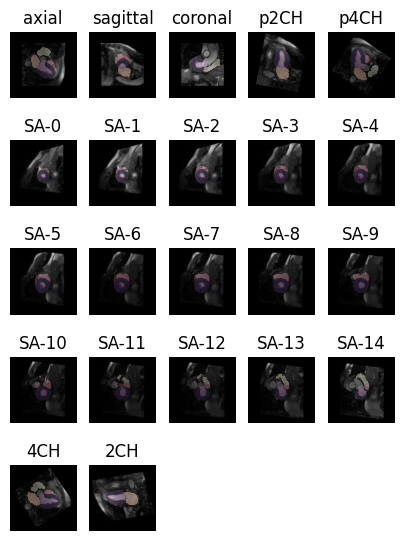



mr_train_1006_image


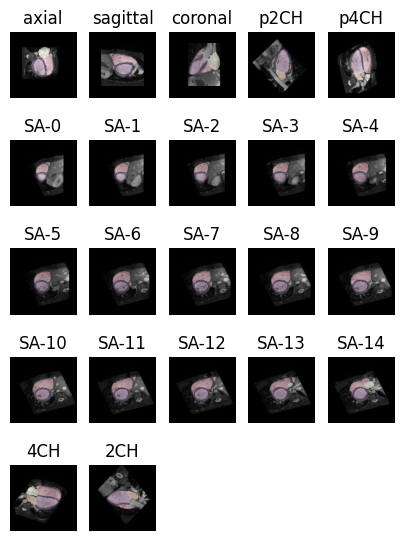



mr_train_1013_image


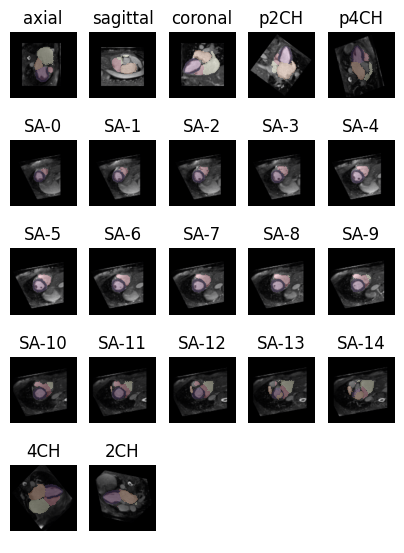



mr_train_1018_image


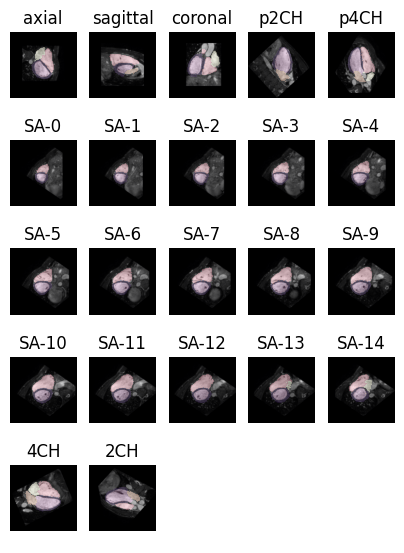

In [12]:
NUM_SA_SLICES = 15

class_dict = dict(
    MYO=1,
    LV=2,
    RV=3,
    LA=4,
    RA=5
)

with open(split_file_path, 'r') as f:
    split_dict = json.load(f)
prepared_paths = split_dict['train_files'] + split_dict['test_files']
metadata_dict = dict()

if True:
    # Crop the images
    FOV_VOX = torch.tensor([128,128,128])
    FOV_MM = 1.5 * FOV_VOX

    for nii_label_path in prepared_paths:
        if not 'label' in nii_label_path: continue

        nii_image_path = nii_label_path.replace("label", "image")
        nii_label = nib.load(nii_label_path)
        nii_image = nib.load(nii_image_path)

        label = torch.as_tensor(nii_label.get_fdata()).int()
        sp_label = label.to_sparse()
        volume_affine = torch.as_tensor(nii_image.affine)
        volume = torch.as_tensor(nii_image.get_fdata())
        class_selected_sp_label = get_sub_sp_tensor(sp_label, eq_value=tuple(class_dict.values()))

        cropped_label, cropped_image, cropped_nii_affine = crop_around_label_center(
            class_selected_sp_label.to_dense()[None,None], volume_affine[None], fov_mm=FOV_MM, fov_vox=FOV_VOX,
            image=volume[None,None])

        nib.save(nib.Nifti1Image(cropped_label[0,0].int().numpy(), affine=cropped_nii_affine[0].numpy()), nii_label_path)
        nib.save(nib.Nifti1Image(cropped_image[0,0].numpy(), affine=cropped_nii_affine[0].numpy()), nii_image_path)

if True:
    display_idx = 0

    for nii_label_path in prepared_paths:
        if not 'label' in nii_label_path: continue
        # if ('mr_train_1015' not in nii_label_path) and ('mr_train_1002' not in nii_label_path): continue
        nii_image_path = nii_label_path.replace("label", "image")
        nii_label = nib.load(nii_label_path)
        nii_image = nib.load(nii_image_path)

        label = torch.as_tensor(nii_label.get_fdata()).int()
        sp_label = label.to_sparse()
        volume_affine = torch.as_tensor(nii_image.affine)
        volume = torch.as_tensor(nii_image.get_fdata())

        clinical_view_affines = get_clinical_cardiac_view_affines(
            sp_label, volume_affine, class_dict, num_sa_slices=NUM_SA_SLICES, return_unrolled=True, debug=False
        )

        image_id = nii_image_path.split('/')[-1].replace('.nii.gz', '')
        metadata_dict[image_id] = dict(view_affines={name:affine.tolist() for name, affine in clinical_view_affines.items()})

        if display_idx % 5 == 0:
            # Print every 5th sample
            print(image_id)
            display_clinical_views(volume, sp_label, volume_affine, clinical_view_affines,
                # output_to_file=f'corrected_clinical_{image_id}.png'
            )
            print()
            print()

        display_idx +=1

    with open(metadata_file_path, 'w') as f:
        json.dump(metadata_dict, f, indent=4)